In [ ]:
"""
Here's a complete implementation of Node2Vec using PyTorch Geometric (PyG) for node classification
Including data loading, model setup, training, and evaluation:
"""

In [1]:
# Purpose: Import necessary libraries for graph processing, model training, and evaluation.
import torch
import torch.nn as nn
from torch_geometric.datasets import Planetoid              # Built-in dataset loader
from torch_geometric.nn import Node2Vec                     # Node2Vec implementation
from sklearn.linear_model import LogisticRegression         # For downstream classification
from sklearn.metrics import accuracy_score                  # Evaluation metric
from sklearn.metrics import classification_report           # Evaluation metric
import matplotlib.pyplot as plt                             # Visualization
from sklearn.decomposition import PCA                       # Visualization

In [2]:
# 2. Device Configuration - Purpose: Use GPU if available for faster training.
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# 3. Load Dataset 
"""
Data Structure:
    * data.x: Node features (shape: [num_nodes, num_features])
    * data.edge_index: Graph edges (shape: [2, num_edges])
    * data.y: Node labels (shape: [num_nodes])
    * data.train_mask/data.test_mask: Boolean masks for train/test splits.
    * train_mask: Nodes used to train the model.
    * val_mask: Identifies nodes used for validation (hyperparameter tuning/early stopping).
    * test_mask: Identifies nodes used only for final evaluation.
"""

path = 'C:/Users/Majid/Downloads/CNN'
dataset = Planetoid(root=path, name='Cora')  # Download Cora dataset
data = dataset[0].to(device)  # Move graph data to GPU/CPU

print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
# 4. Initialize Node2Vec Model
# p=1.0: Low value encourages revisiting previous nodes (BFS-like).
# q=1.0: Low value explores distant nodes (DFS-like).

Node2VecModel = Node2Vec(
    edge_index=data.edge_index,  # Graph connectivity
    embedding_dim=128,          # Dimension of node embeddings
    walk_length=20,             # Length of each random walk
    context_size=10,            # Skip-gram window size
    walks_per_node=10,          # Number of walks per node
    p=1.0,                     # Return parameter (BFS control)
    q=1.0,                     # In-out parameter (DFS control)
    sparse=True                 # Memory-efficient sparse gradients
).to(device)

In [5]:
# 5. Training Setup
# loader: Generates batches of random walks.
# SparseAdam: Optimizer for sparse embeddings (memory-efficient).

loader = Node2VecModel.loader(batch_size=128, shuffle=True)  # Data loader for walks
optimizer = torch.optim.SparseAdam(Node2VecModel.parameters(), lr=0.01)  # Optimizer

In [6]:
# 6. Training Loop

def train():
    """
    1. Setting a model to train
    Node2VecModel.train(): Switches the model to training mode
    (important if the model has layers like dropout or batch normalization, though Node2Vec doesn’t use them).
    """
    Node2VecModel.train()   # Set model to training mode

    # Initializes a variable to accumulate the loss over all batches in the epoch.
    total_loss = 0  # Initialize loss accumulator

    """
    2. Iterate Over Batches of Walks
    
    loader:
    A PyTorch Geometric data loader that yields batches of:
        *   pos_rw: Positive random walks (node sequences that co-occur in the graph).
        *   neg_rw: Negative random walks (random node pairs not observed together).
    
    Each batch contains a subset of walks for efficient training.
    """
    for pos_rw, neg_rw in loader:  # Get batches of positive/negative walks

        """PyTorch accumulates gradients by default. 
        # This resets them to zero before backpropagation to avoid mixing gradients across batches."""
        optimizer.zero_grad()      # Clear previous gradients

        """ 
            model.loss(pos_rw, neg_rw):
            Computes the skip-gram loss (a contrastive loss):
                *   Maximizes similarity for nodes that co-occur in walks (pos_rw).
                *   Minimizes similarity for randomly sampled node pairs (neg_rw).
            
            The loss function is defined in PyG’s Node2Vec module.
            Moves the data to GPU/CPU based on the device setting.
        """ 
        loss = Node2VecModel.loss(pos_rw.to(device), neg_rw.to(device))  # Skip-gram loss (Calculate loss)

        """ 
            Computes gradients of the loss with respect to the model parameters (embeddings). 
        """
        loss.backward()    # Backpropagate gradients

        """
            Updates the embeddings using the gradients (via SparseAdam in this case).
        """
        optimizer.step()   # Update model parameters

        """
            loss.item():
                   Extracts the scalar value of the loss (to avoid holding computation graph in memory).
            total_loss:
                   Tracks the cumulative loss for the epoch.
        """
        total_loss += loss.item()  # Add batch loss to total

    """
       Divides the total loss by the number of batches to get the average loss per batch for the epoch.
    """
    return total_loss / len(loader)  # Return Average Loss

# Trains the model for 10 epochs (complete passes through the data).
for epoch in range(1, 11):
    loss = train()                                    # Calls the train() function for each epoch and records the average loss.
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')    # Logs the epoch number and loss (e.g., Epoch: 05, Loss: 2.1234).

Epoch: 01, Loss: 8.1074
Epoch: 02, Loss: 6.0659
Epoch: 03, Loss: 4.9659
Epoch: 04, Loss: 4.1407
Epoch: 05, Loss: 3.4886
Epoch: 06, Loss: 2.9608
Epoch: 07, Loss: 2.5494
Epoch: 08, Loss: 2.2214
Epoch: 09, Loss: 1.9554
Epoch: 10, Loss: 1.7444


In [7]:
# 7. Generate Embeddings
"""
    * Node2VecModel.eval(): 
         - Switches the model to evaluation mode.
    * embeddings = Node2VecModel(): 
        - Calls the forward pass of the Node2Vec model.
        - Returns the embedding matrix of shape [num_nodes, embedding_dim] (e.g., [2708, 128] for Cora).
    * .detach(): 
        - Detaches the embeddings from the PyTorch computation graph.
        - This means gradients won't be tracked for these embeddings (saves memory and speeds up operations).
        - Critical because we're done training and just want to use the embeddings.
    * .cpu():
        - Moves the embeddings from GPU (if they were on GPU) to CPU.
        - Necessary because NumPy (next step) only works with CPU tensors.
        - If no GPU was used, this is a no-op.
    * .numpy()
        - Converts the PyTorch tensor to a NumPy array.
        - NumPy arrays are easier to use with:
          # Scikit-learn (e.g., for logistic regression).
          # Visualization libraries (e.g., Matplotlib, Seaborn).
          # Traditional ML pipelines.
"""

Node2VecModel.eval()  # Evaluate the model.

embeddings = Node2VecModel().detach().cpu().numpy()  # Get embeddings (shape: [num_nodes, 128])

print(embeddings.shape)  # Output: (2708, 128)
print(embeddings.dtype)  # Output: float32

(2708, 128)
float32


In [8]:
# 8. Node Classification (Use embeddings as features for node classification)

"""
    data.train_mask and data.test_mask are boolean tensors indicating which nodes belong to the training/test sets.
    .cpu(): Ensures the tensor is on CPU (necessary if the data was on GPU).
    .numpy(): Converts PyTorch tensor to NumPy array for compatibility with scikit-learn.
"""
train_mask = data.train_mask.cpu().numpy()  # Convert to NumPy array on CPU for train mask
test_mask = data.test_mask.cpu().numpy()    # Convert to NumPy array on CPU for test mask
print(train_mask[:5])  # e.g., [True, False, True, False, True]
print(sum(train_mask)) # e.g., 140 (number of training nodes in Cora)

clf = LogisticRegression()                 # Simple classifier

"""
    Inputs:
        * embeddings[train_mask]: Embeddings of training nodes (shape: [num_train_nodes, embedding_dim]).
        * data.y[train_mask]: Ground-truth labels of training nodes (shape: [num_train_nodes]).
        * data.y.cpu().numpy() ensures labels are in NumPy format (required by scikit-learn).
"""
clf.fit(embeddings[train_mask], data.y.cpu().numpy()[train_mask])  # Train on embeddings

"""
    Input:
        * embeddings[test_mask]: Embeddings of test nodes (shape: [num_test_nodes, embedding_dim]).
    Output:
        * pred: Predicted labels for test nodes (shape: [num_test_nodes]).
"""
preds = clf.predict(embeddings[test_mask])  # Predict labels for test nodes
print(preds[:5])  # e.g., [2, 2, 5, 3, 4] (first 5 test node labels)

"""
    Extracts the true labels for test nodes to evaluate prediction accuracy.
"""

true_labels = data.y.cpu().numpy()[test_mask]   # Ground-truth test labels
print(true_labels[:5])  # e.g., [3, 2, 5, 1, 4] (first 5 test node labels)

print(f"The total number of labels that the data set has is: {len(set(data.y.cpu().numpy()))}") # Number of labels in dataset

[ True  True  True  True  True]
140
[3 2 2 2 2]
[3 2 2 2 2]
The total number of labels that the data set has is: 7


In [9]:
# 9. Evaluation (Accuracy of predicted node labels vs. ground truth)
accuracy = accuracy_score(true_labels, preds)
print(f'Test Accuracy: {accuracy:.4f}')  # e.g., 0.7520

print("Classification Report:")
print(classification_report(true_labels, preds))

Test Accuracy: 0.4280
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.46      0.39       130
           1       0.50      0.58      0.54        91
           2       0.68      0.74      0.71       144
           3       0.65      0.29      0.40       319
           4       0.34      0.34      0.34       149
           5       0.33      0.48      0.39       103
           6       0.15      0.28      0.19        64

    accuracy                           0.43      1000
   macro avg       0.43      0.45      0.42      1000
weighted avg       0.49      0.43      0.43      1000



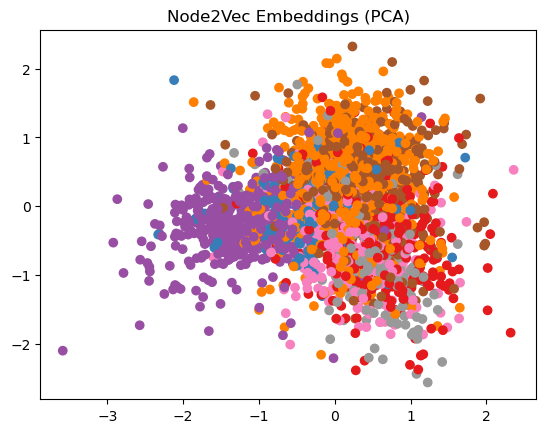

In [10]:
# 10. Visualization (Optional)

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)  # Reduce to 2D for plotting

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=data.y.cpu().numpy(), cmap='Set1')
plt.title('Node2Vec Embeddings (PCA)')
plt.show()